In [53]:
import numpy as np

import qiskit
from qiskit.visualization import *
import qiskit.aqua.components.optimizers as optimizers

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

## Variational quantum eigensolver

### Single qubit variational form

In [35]:
class VariationalForm:

    def __init__(self, n_qubits, backend, iterations):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.theta = qiskit.circuit.Parameter('theta')
        self.phi = qiskit.circuit.Parameter('phi')
        self.lamda = qiskit.circuit.Parameter('lamda')

        self._circuit.u3(self.theta, self.phi, self.lamda, all_qubits)
        self._circuit.measure_all()
        
        self.backend = backend
        self.iterations = iterations
    
    def run(self, params):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.iterations,
                             parameter_binds = [{self.theta: params[0], 
                                                 self.phi: params[1],
                                                 self.lamda: params[2]}])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        probabilities = counts / self.iterations
        
        if not '0' in result.keys():
            probabilities = np.append(np.array(0), probabilities)
        if not '1' in result.keys():
            probabilities = np.append(probabilities, np.array(0))

        return np.array(probabilities)

[0.46 0.54]


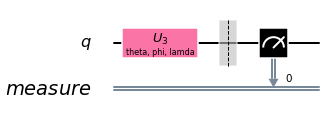

In [36]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = VariationalForm(1, simulator, 100)
print(circuit.run([np.pi / 2, np.pi / 3, 1]))
circuit._circuit.draw()

In [38]:
import scipy.spatial.distance as distance

def loss(circuit, y_true):
    return lambda params: distance.cityblock(circuit.run(params), y_true)

Target distribution is set to [0.47867463 0.52132537]


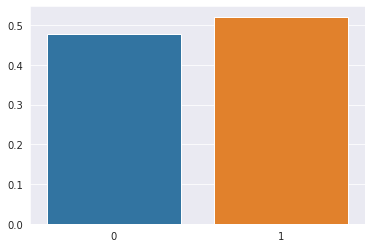

In [39]:
target_distribution = np.random.rand(2)
target_distribution /= np.sum(target_distribution)

print('Target distribution is set to {}'.format(target_distribution))
sns.barplot(x = [0,1], y = target_distribution)

In [55]:
simulator = qiskit.Aer.get_backend('qasm_simulator')
circuit = VariationalForm(1, simulator, 100)

# Constrained Optimization by Linear Approximation optimizer
optimizer = optimizers.COBYLA(maxiter = 500, tol = 0.0001)
params, error, _ = optimizer.optimize(num_vars = 3,
                                      objective_function = loss(circuit, target_distribution), 
                                      initial_point = np.random.rand(3))

predicted_distribution = circuit.run(params)

np.set_printoptions(precision=2)
print("Target distribution:       {}".format(target_distribution))
print("Predicted distribution:    {}".format(predicted_distribution))
print("Prediction error:          {0:0.4f}".format(error))

Target distribution:       [0.48 0.52]
Predicted distribution:    [0.47 0.53]
Prediction error:          0.0573
